<a href="https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn?scriptVersionId=160805486" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Welcome to my Object segmentation project!
## This project was my attempt at the *Sartorius - Cell Instance Segmentation* Kaggle problem!
## Much of what I did was based on other notebooks publicly available in <a href="https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/code">the "code" part of the competition</a>, more information on what especific noteboooks I used can be found in References

## These are the basic libraries used, I tried to keep it to a minimum in order to extract torch to its highest potential
## The decision to use the Mask R-cnn architecture was based in <a href="https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279790">this discussion</a>

In [1]:
import os
import time
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, maskrcnn_resnet50_fpn_v2, roi_heads



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting seeds for all future random instaces, in order to prevent random outcomes from random numbers generators.
### Example:
#### np.random.seed(0) makes the random numbers predictable:

```
>>> numpy.random.seed(0) ; numpy.random.rand(4)
array([ 0.55,  0.72,  0.6 ,  0.54])
>>> numpy.random.seed(0) ; numpy.random.rand(4)
array([ 0.55,  0.72,  0.6 ,  0.54])
```

In [2]:
def __set__seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
__set__seeds(2024)

## Useful constants and mask r-cnn hyperparameters

In [3]:
BASE_PATH = "/kaggle/input/sartorius-cell-instance-segmentation"
TRAIN_PATH = BASE_PATH + "/train"
TEST_PATH = BASE_PATH + "/test"
TRAIN_CSV = BASE_PATH + "/train.csv"

IMG_WIDTH = 704
IMG_HEIGHT = 520

TEST = False

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Will be used to normalize pictures
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 2

MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Confidence required for a pixel to be kept for a mask
MASK_THRESHOLD = 0.5

# Dictionaries to classify each type of cell
CELL_TYPE_DICT = {"astro": 1, "cort": 2, "shsy5y": 3}
DICT_TO_CELL = {1: "astro", 2: "cort", 3: "shsy5y"}
MASK_THRESHOLD_DICT = {1: 0.55, 2: 0.75, 3:  0.6}
MIN_SCORE_DICT = {1: 0.55, 2: 0.75, 3: 0.5}

# Normalize to resnet mean and std if True.
NORMALIZE = True 


# Using a learning rate scheduler
USE_SCHEDULER = True

# Number of epochs in training
NUM_EPOCHS = 8

BOX_DETECTIONS_PER_IMG = 539

## Transformations used in training dataset
### Only used vertical flip, normalization and horizontal flip.

In [4]:
# These are slight redefinitions of torch.transformation classes, they are needed because of the masks created
# The difference is that they handle the target and the mask
# From Abishek and DATAISTA0

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    
    
def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for training dataset
    if train: 
        if NORMALIZE: 
            transforms.append(Normalize())
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))
        
    return Compose(transforms)

## Auxiliary functions
### These functions vary a lot in what aspect they've helped in the project. From rle encoding/decoding to computing IoU scores.
### IoU score funtions where taken from <a href="https://www.kaggle.com/theoviel/competition-metric-map-iou">this notebook</a>.


In [5]:
def rle_decode(mask_rle, shape, color=1):
    
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def rle_encoding(x):
    '''
    x : image to be encoded 
    Returns string of encoded image
    '''
    
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask


def draw_box(box):
    '''
    box: list of four elements organized like : [xmin, ymin, xmax, ymax]
    
    Returns image with 1's where box should be in a image with dimensions IMG_WIDTH x IMG_HEIGHT 
    '''
    
    result = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    xmin = int(box[0])
    ymin = int(box[1])
    xmax = int(box[2])
    ymax = int(box[3]) 
    
    for x in range(xmin, xmax):
        if (xmin != 0) and (xmax != IMG_WIDTH):
            result[ymin-1][x] = 1
            result[ymax-1][x] = 1
            
    for y in range(ymin, ymax):
        if (ymin != 0) and (ymax != IMG_HEIGHT):
            result[y][xmax-1] = 1
            result[y][xmin-1] = 1
            
    return result


def get_box(a_mask):
    ''' 
    Get the bounding box of a given mask.
    '''

    pos = np.where(a_mask)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])

    return [xmin, ymin, xmax, ymax]


def combine_masks(masks, mask_threshold):
    """
    Combine masks into one image.
    """
    maskimg = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg


def combine_masks_boxes(masks, boxes):
    '''
    masks: image with several masks, marked as non-zero values and background as 0`s.
    boxes: image with several boxes, marked as 1's and background as 0`s.
    Returns image with both the boxes and masks, taking in consideration their values.
    Boxes will have the max value possible.
    '''
    result = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    cur_max = 0
    for i in range(IMG_WIDTH):
        for j in range(IMG_HEIGHT):
            
            result[j][i] = 0
            
            if masks[j][i] != 0:
                result[j][i] = masks[j][i]
                if masks[j][i] > cur_max:
                    cur_max = masks[j][i]
                    
                    
    for i in range(IMG_WIDTH):
        for j in range(IMG_HEIGHT):
            if boxes[j][i] != 0:
                result[j][i] = cur_max                
    return result


def get_filtered_masks(pred):
    """
    Filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []   
    for i, mask in enumerate(pred["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > MIN_SCORE_DICT[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > MASK_THRESHOLD_DICT[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks


def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    
    return iou  


def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn


def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = MASK_THRESHOLD_DICT[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

## Dataset constructor
### Created training dataset first, test dataset will be constructed afterwards!
### Cell types were differenciated, heavily inspired by <a href="https://www.kaggle.com/code/rluethy/sartorius-torch-mask-r-cnn"> rluethy's notebook</a>

In [6]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.height = IMG_HEIGHT
        self.width = IMG_WIDTH
        self.image_info = collections.defaultdict(dict)
        
        temp_df = self.df.groupby(['id', 'cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
        
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': row["annotation"],
                    'cell_type': CELL_TYPE_DICT[row["cell_type"]]
                    }
    


    def __getitem__(self, idx):
        ''' Get the image and the target'''
        
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        info = self.image_info[idx]
        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        
        for i, annotation in enumerate(info['annotations']):
            
            a_mask = rle_decode(annotation, (IMG_HEIGHT, IMG_WIDTH))
            a_mask = Image.fromarray(a_mask)
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            boxes.append(get_box(a_mask))
            
        # dummy labels
        labels = [info["cell_type"] for _ in range(n_objects)]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # This is the required target for the Mask R-CNN in torch usage
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.image_info)

## Create instances of the classes previously created as well as explore some of the data

In [7]:
df_train = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)
ds_train = CellDataset(TRAIN_PATH, df_train, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, 
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


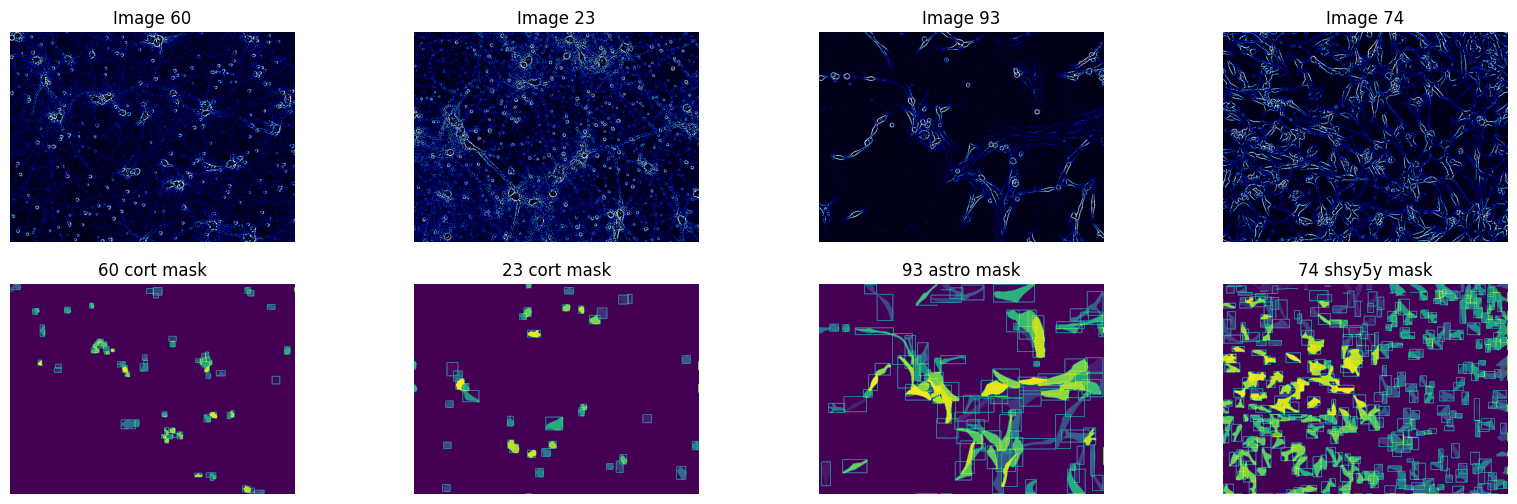

In [8]:
def sample_images(ncols):
    '''
    ncols : number of images to sample
    Returns plot with 2x(ncols) images from training dataset 
    '''
    ns = random.sample(range(100), ncols)
    fig, axs = plt.subplots(2, ncols, figsize=(20, 6)) 
    
    for i in range(ncols):
        img, targets = ds_train[ns[i]]
        masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        axs[0][i].set_title(f"Image {ns[i]}")
        axs[0][i].imshow(img.numpy().transpose((1,2,0)))
        axs[0][i].axis("off")
        

        for mask in targets['masks']:
            box = get_box(mask)
            boxes = np.logical_or(boxes, draw_box(box))
            
        masks = combine_masks(targets['masks'], 0.5)
            
        axs[1][i].set_title(f"{ns[i]} {DICT_TO_CELL[((targets['labels'])[0]).item()]} mask")
        detections = combine_masks_boxes(masks, boxes)
        axs[1][i].imshow(detections)
        axs[1][i].axis("off")
    plt.show()
sample_images(4)

## Create main mask r-cnn model
### I opted to use the new experimental model in the torch vision repository 

In [9]:
def get_model():
    # This is just a dummy value for the classification head
    NUM_CLASSES = len(CELL_TYPE_DICT)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT, box_detections_per_img=BOX_DETECTIONS_PER_IMG)
    
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES+1)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 128
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES+1)
    return model


# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS
model = get_model()
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
    
model.train();

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:03<00:00, 48.0MB/s]


## Train the model

In [10]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

n_batches = len(dl_train)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch} of {NUM_EPOCHS}:")
    
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
        # Predict
        images = list(image.to(DEVICE) for image in images)
        
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        loss = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
         # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        loss_classifier_accum += loss_dict['loss_classifier'].item()
        
        # Train losses
        train_loss = loss_accum / n_batches
        train_loss_mask = loss_mask_accum / n_batches
        train_loss_classifier = loss_classifier_accum / n_batches

        
        if batch_idx % 50 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")
            
    if USE_SCHEDULER and epoch >= 5:
        lr_scheduler.step()
   
    
    # Total network loss
    network_loss = train_loss + train_loss_mask + train_loss_classifier
    
    
    
    elapsed = time.time() - time_start
    
    
    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")
    print(f"{prefix} Train Classifier loss: {train_loss_classifier:7.3f}")
    print(f"{prefix} Total network loss: {network_loss:7.3f}")

Epoch 1 of 8:
    [Batch  50 / 303] Batch train loss:   2.378. Mask-only loss:   0.554
    [Batch 100 / 303] Batch train loss:   1.926. Mask-only loss:   0.409
    [Batch 150 / 303] Batch train loss:   1.890. Mask-only loss:   0.350
    [Batch 200 / 303] Batch train loss:   2.267. Mask-only loss:   0.382
    [Batch 250 / 303] Batch train loss:   1.514. Mask-only loss:   0.318
    [Batch 300 / 303] Batch train loss:   1.785. Mask-only loss:   0.334
[Epoch  1 /  8] Train mask-only loss:   0.416
[Epoch  1 /  8] Train loss:   2.127. [173 secs]
[Epoch  1 /  8] Train Classifier loss:   0.495
[Epoch  1 /  8] Total network loss:   3.038
Epoch 2 of 8:
    [Batch  50 / 303] Batch train loss:   1.923. Mask-only loss:   0.313
    [Batch 100 / 303] Batch train loss:   1.474. Mask-only loss:   0.298
    [Batch 150 / 303] Batch train loss:   1.582. Mask-only loss:   0.324
    [Batch 200 / 303] Batch train loss:   1.391. Mask-only loss:   0.285
    [Batch 250 / 303] Batch train loss:   1.929. Mask-onl

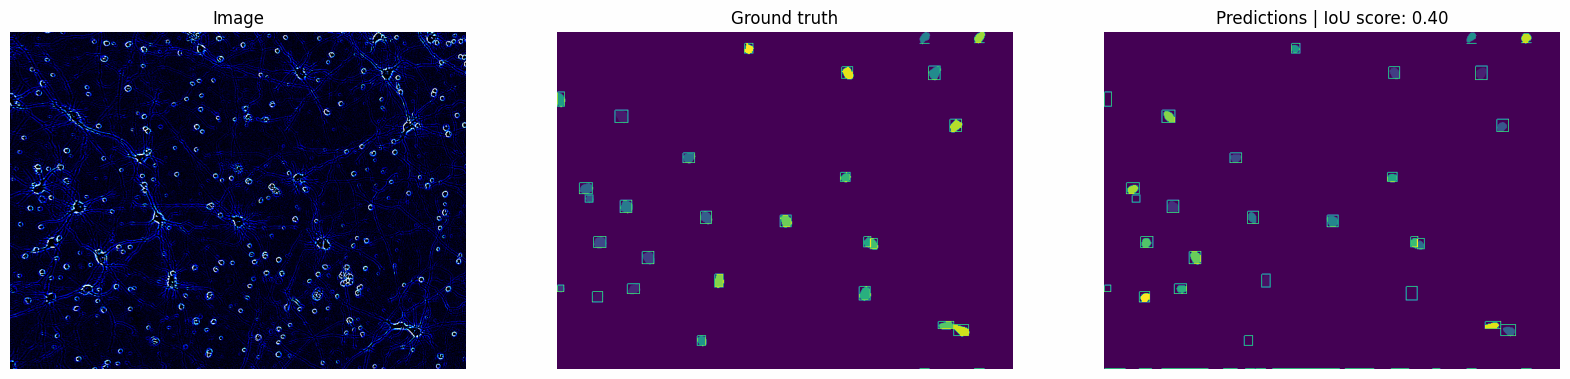

In [11]:
# Plots: the image, The image + the ground truth mask + detection boxes, The image + the predicted mask + predicted boxes
def analyze_sample(model, ds_train, sample_index):
    '''
    model : model used to create the masks/boxes of the object detection
    ds_train : data set to take samples from
    sample_index: index of the image that will be used
    Returns grid 1x3 with : the image | the image + the ground truth mask + detection boxes | the image + the predicted mask + predicted boxes
    '''
    img, targets = ds_train[sample_index]
    fig, axs = plt.subplots(1, 3, figsize=(20, 40), facecolor="#fefefe") 
    
    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    
    axs[0].imshow(img.numpy().transpose((1,2,0)))
    axs[0].set_title("Image")
    axs[0].axis("off")
    
    for mask in targets['masks']:
        box = get_box(mask)
        boxes = np.logical_or(boxes, draw_box(box)) 
        
    masks = combine_masks(targets['masks'], 0.5)
    detections = combine_masks_boxes(masks, boxes)
    axs[1].imshow(detections)
    axs[1].set_title("Ground truth")
    axs[1].axis("off")
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    axs[2].imshow(img.cpu().numpy().transpose((1,2,0)))
    
    for mask in preds['masks'].cpu().detach():
        box = get_box(mask[[0]])
        boxes = np.logical_or(boxes, draw_box(box))
        
    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
    lstr = ""
    for i in l.index:
        lstr += f"{l[i]}x{i} "
    mask_threshold = MASK_THRESHOLD_DICT[l.sort_values().index[-1]]
    pred_masks = combine_masks(get_filtered_masks(preds), 0.5)
        
       
    detections = combine_masks_boxes(pred_masks, boxes)
    score = iou_map([masks],[pred_masks])
    axs[2].imshow(detections)
    axs[2].set_title(f"Predictions | IoU score: {score:.2f}")
    axs[2].axis("off")
    plt.show()
analyze_sample(model, ds_train, random.randint(1, 500))


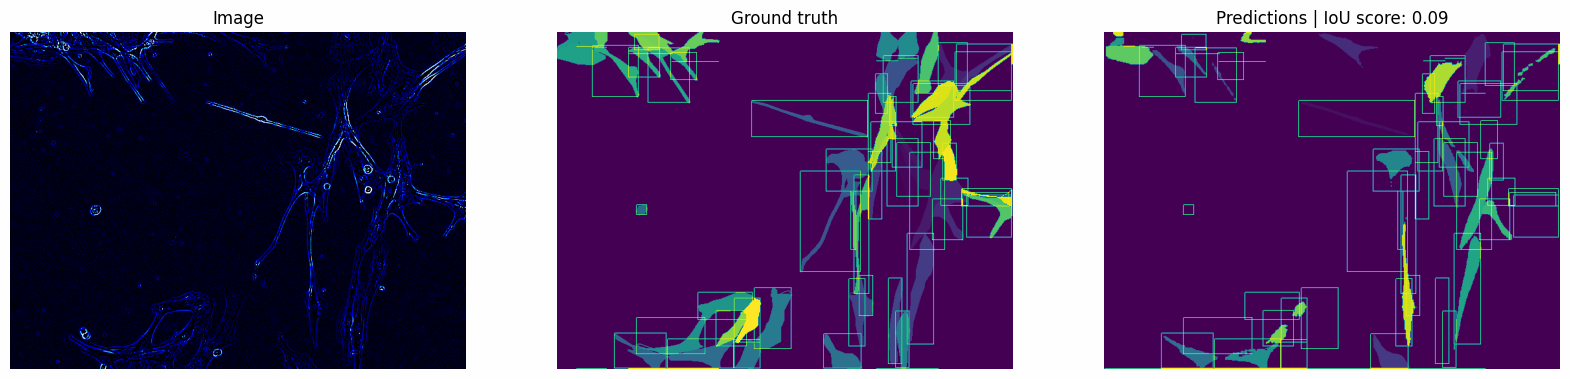

In [12]:
analyze_sample(model, ds_train, random.randint(1, 500))

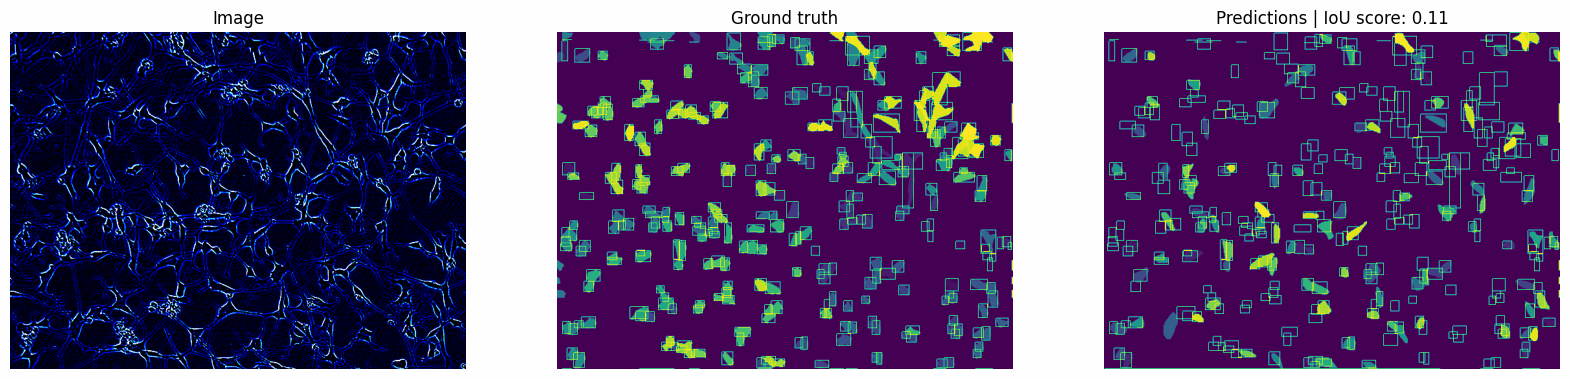

In [13]:
analyze_sample(model, ds_train, random.randint(1, 500))

In [14]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert("RGB")

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        return {'image': image, 'image_id': image_id}

In [15]:
ds_test = CellTestDataset(TEST_PATH, transforms=get_transform(train=False))


## Encode masks results, append results to submissions list!

In [16]:
model.eval();

submission = []
for sample in ds_test:
    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    
    previous_masks = []
    for i, mask in enumerate(result["masks"]):
        score = result["scores"][i].cpu().item()
        mask = mask.cpu().numpy()
        # Keep only highly likely pixels
        binary_mask = mask > MASK_THRESHOLD
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))
    
    # Add empty prediction if no RLE was generated for this image
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
df_sub.to_csv("submission.csv", index=False)
df_sub.head()

,id,predicted
0,7ae19de7bc2a,2560 6 3264 8 3967 10 4671 11 5376 10 6079 11 ...
1,7ae19de7bc2a,235970 5 236674 7 237378 9 238082 10 238786 11...
2,7ae19de7bc2a,229665 14 230368 16 231072 17 231776 17 232480...
3,7ae19de7bc2a,336155 9 336858 11 337561 13 338265 14 338969 ...
4,7ae19de7bc2a,295999 10 296702 12 297406 12 298110 12 298814...


## References
### This notebook was extremely inspired by other notebooks that competed in the past, such as: <a href="https://www.kaggle.com/theoviel/competition-metric-map-iou">this notebook (IoU)</a>, <a href="https://www.kaggle.com/code/rluethy/sartorius-torch-mask-r-cnn"> rluethy's notebook</a>, <a href="https://www.kaggle.com/code/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-273">DATAISTA0's notebook</a>
### Thanks for checking out my project!